In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import xgboost as xgb


def fit_models(df):
    
    df = df.dropna()
    train_size = int(len(df) * 0.9)
    train = df.iloc[:train_size, :]
    test = df.iloc[train_size:, :]

    target_name = df.columns[-1]
    train_X = train.drop(target_name, axis = 1)
    train_y = train[target_name]

    test_X = test.drop(target_name, axis = 1)
    test_y = test[target_name]
    
    models = []
    
    #Decision Tree
    models.append(('DT', DecisionTreeClassifier(max_depth=5)))
    
    # Random Forest
    models.append(('RF', RandomForestClassifier(max_depth=5)))
    
    # Gradient Boosting
    models.append(('GB', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5)))
    
    # XGBoost
    models.append(('XGB', xgb.XGBClassifier(use_label_encoder=False, eval_metric='error')))
    models.append(('SVC', SVC()))
    models.append(('KNN', KNeighborsClassifier()))
    
    # Logistic Regression
    models.append(('LR', LogisticRegression()))
    
    # Naive Bayes
    models.append(('NB', GaussianNB()))

    accuracies = dict()

    for name, model in models:

        model.fit(train_X, train_y)
        hyp = model.predict(test_X)
        accuracies[name] = accuracy_score(test_y, hyp) * 100.0
        
    return accuracies

In [2]:
import stock_helper
import pandas as pd
from datetime import datetime
import numpy as np

def date_to_day(df):
    # Convert date to the n-th day from 1970-01-01
    df['date'] = df['date'] \
        .apply(lambda date64: (date64 - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 'D'))

stocks = ['AAPL', 'GOOG', 'AMD', 'TSLA', 'JPM', 'UAL']
stocks_dataset = [None] * len(stocks)

for i in range(len(stocks)):
    dataset = stock_helper.fetch_stock_data(stocks[i])
    stocks_dataset[i] = stock_helper.generate_indicators(dataset, 
                                     timeperiod=5, 
                                     generate_target=True, 
                                     reset_index=True)
    
    date_to_day(stocks_dataset[i])

In [3]:
dataset_accuracy = dict()
for i, df in enumerate(stocks_dataset):
    dataset_accuracy[stocks[i]] = fit_models(df)


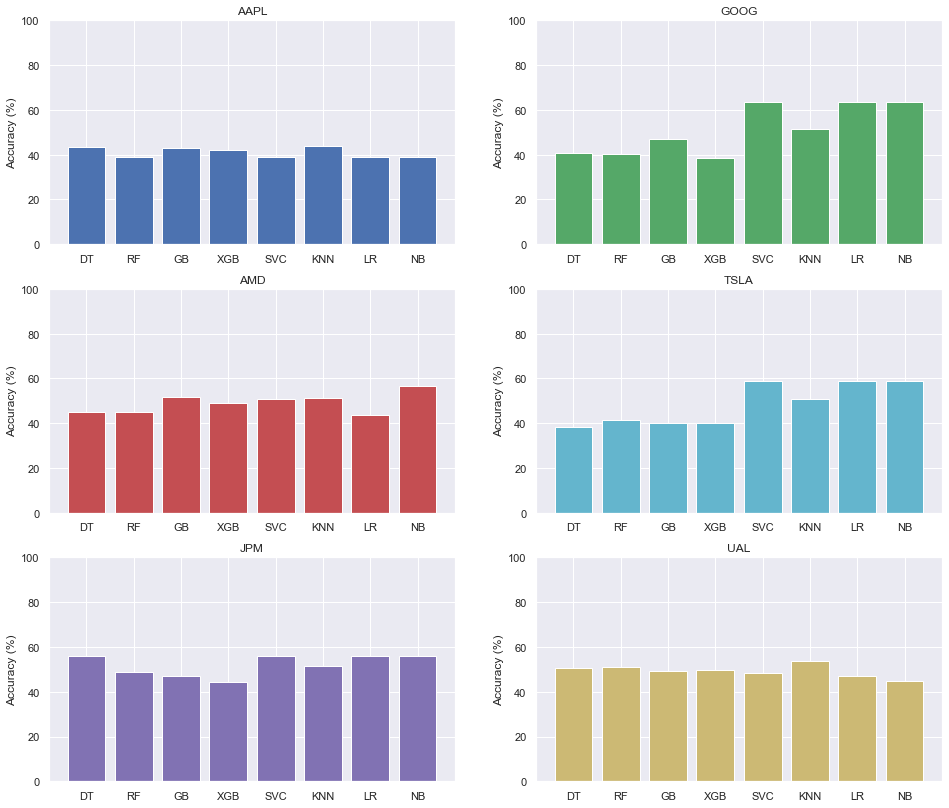

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,14))

colors = ['b', 'g', 'r', 'c', 'm', 'y']
i = 0
for stock_name in dataset_accuracy:    
    data = dataset_accuracy[stock_name]
    ax_row = int(i/2)
    ax_colm = i % 2
    ax = axes[ax_row, ax_colm]
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim(0, 100)
    ax.set_title(stock_name)
    ax.bar(data.keys(), data.values(), color=colors[i])
    i+= 1

In [5]:
for stock_name in dataset_accuracy:
    acc = dataset_accuracy[stock_name]
    highest = sorted(acc, key=acc.get, reverse=True)[:1]
    print("The best model for {stockname} is {model}, accuracy is {acc:.2f}%".format(stockname=stock_name,
                                                                                    model=highest[0],
                                                                                    acc=acc[highest[0]]))

The best model for AAPL is KNN, accuracy is 44.00%
The best model for GOOG is SVC, accuracy is 63.40%
The best model for AMD is NB, accuracy is 56.43%
The best model for TSLA is SVC, accuracy is 58.67%
The best model for JPM is DT, accuracy is 56.14%
The best model for UAL is KNN, accuracy is 53.81%


# Tensorflow LSTM

In [430]:
from sklearn import preprocessing

history_points = 25

def get_features(dataset):
    data = dataset.copy()
    
    target_name = data.columns[-1]
    data = data.drop(target_name, axis=1)
    data = data.to_numpy()

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    
    # get the history_points * 5 features (open, clos, volum, etc) array * (rows - history_points) 
    features = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    return features

In [431]:
df_all = df_all.iloc[50:]
print(df_all)
X = get_features(df_all)
result = df_all['next_2day_trend'].iloc[history_points:]
Y = np.expand_dims(result, axis=-1)
print(len(X))
print(len(Y))

         date         high          low         open        close    volume  \
200   12940.0   147.022018   141.056061   141.336334   145.615616  45006748   
201   12941.0   149.944946   145.295288   148.698700   146.706711  48597354   
202   12942.0   146.741745   139.139145   146.571579   139.919922  51350398   
203   12943.0   144.394394   140.420425   142.502502   143.298294  32849318   
204   12944.0   143.783783   140.150146   143.638641   141.391388  25367807   
...       ...          ...          ...          ...          ...       ...   
4206  18752.0  2335.000000  2308.280029  2328.629883  2314.770020   1331800   
4207  18753.0  2337.350098  2293.040039  2306.330078  2337.350098   1259500   
4208  18754.0  2371.250000  2346.159912  2363.889893  2351.929932   1444500   
4209  18757.0  2331.000000  2284.540039  2328.139893  2291.750000   1544900   
4210  18758.0  2279.989990  2234.369629  2243.070068  2270.060059   1709292   

            RSI        MOM      slowk      slowd   

In [471]:
from sklearn.model_selection import train_test_split
    
print(X.shape)
print(Y.shape)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
print(len(x_train))
print(len(x_test))

(3986, 25, 18)
(3986, 1)
2989
997


In [472]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer,Embedding,SpatialDropout1D

# model definition
lstm_input = Input(shape=(history_points, 18), name='lstm_input')
x = LSTM(history_points, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(32, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
# output = tf.nn.softmax(x)
model = Model(inputs=lstm_input, outputs=x)

adam = optimizers.Adam(lr=0.001)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [473]:
model.fit(x=train_X,
          y=train_y,
          batch_size=32,
          epochs=25)

Epoch 1/25
94/94 [==============================] - 3s 10ms/step - loss: 0.7008 - accuracy: 0.5250
Epoch 2/25
94/94 [==============================] - 1s 10ms/step - loss: 0.6931 - accuracy: 0.5175
Epoch 3/25
94/94 [==============================] - 1s 10ms/step - loss: 0.6994 - accuracy: 0.5031
Epoch 4/25
94/94 [==============================] - 1s 10ms/step - loss: 0.6914 - accuracy: 0.5284
Epoch 5/25
94/94 [==============================] - 1s 10ms/step - loss: 0.6908 - accuracy: 0.5225
Epoch 6/25
94/94 [==============================] - 1s 10ms/step - loss: 0.6906 - accuracy: 0.5360
Epoch 7/25
94/94 [==============================] - 1s 10ms/step - loss: 0.6921 - accuracy: 0.5355
Epoch 8/25
94/94 [==============================] - 1s 10ms/step - loss: 0.6923 - accuracy: 0.5312
Epoch 9/25
94/94 [==============================] - 1s 12ms/step - loss: 0.6899 - accuracy: 0.5258
Epoch 10/25
94/94 [==============================] - 1s 10ms/step - loss: 0.6921 - accuracy: 0.5296
Epoch 11/

In [474]:
evaluation = model.evaluate(test_X, test_y)
print(evaluation)

32/32 [==============================] - 1s 3ms/step - loss: 0.6893 - accuracy: 0.5416
[0.6893291473388672, 0.541624903678894]


In [475]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import binarize
import math

y_pred = model.predict(x_test)

y_bin = [y > 0.5 for y in y_pred]

confusion_matrix(y_test, y_bin)

array([[ 22, 438],
       [ 19, 518]])